In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [2]:
import sys

sys.path.append("../src")

In [3]:
from core import SITE_NAMES, FREQ_GROUPS, EXAMPLE_FILES_from_LOCATIONS, EXAMPLE_FILES_to_FILEPATHS, EXAMPLE_FILES_to_DETECTIONS
import bout_clustering as bt_clustering
import bout_plotting as bt_plt
import subsampling as ss
import data_handling as dh

from cli import get_file_paths

In [4]:
site_key = 'Central'
freq_key = 'LF1'

bout_params = dict()
bout_params['site_key'] = site_key
bout_params['freq_key'] = freq_key

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
fig_details['freq_group'] = freq_key.split('_')[0].upper()
if freq_key:
    fig_details['freq_group'] = fig_details['freq_group'] + ' '
fig_details['bin_step'] = 10
fig_details['time_end'] = 2000
print(f'Looking at {fig_details["site_name"]}')

Looking at Central Pond


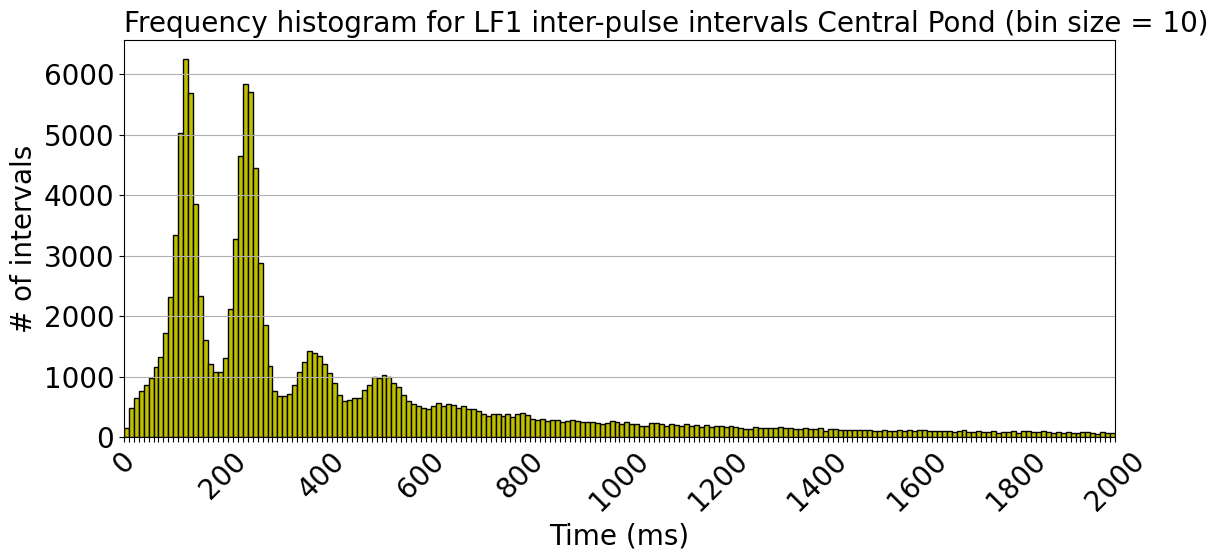

In [5]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_f, hist_f = bt_plt.plot_ipi_hist(location_df, fig_details)

In [6]:
location_df = pd.read_csv(f'../data/2022_bd2_summary/{bout_params["site_key"]}/bd2__{bout_params["freq_key"]}{bout_params["site_key"]}_2022.csv', index_col=0)
ipis_loc, hist_loc = bt_clustering.get_histogram(location_df, fig_details['bin_step'])
intervals_ms, survival = bt_clustering.get_log_survival(hist_loc)

fast_process = bt_clustering.regress_around_peakIPI(intervals_ms, survival, hist_loc[0])
fast_process = bt_clustering.calculate_exponential_coefficients(fast_process)

slow_process = bt_clustering.regress_around_slow_intervals(intervals_ms, survival)
slow_process = bt_clustering.calculate_exponential_coefficients(slow_process)

fg_bci, misassigned_points_fg = bt_clustering.get_bci_from_fagenyoung_method(fast_process, slow_process)
print(f"Fagen&Young method has {round(misassigned_points_fg)} missassigned points")
bci, misassigned_points = bt_clustering.get_bci_from_slater_method(fast_process, slow_process)
print(f"Slater method has {round(misassigned_points)} missassigned points")
nlin_results, misassigned_points_optim = bt_clustering.get_bci_from_sibly_method(intervals_ms, survival, fast_process, slow_process)
print(f"Sibly method has {round(misassigned_points_optim)} missassigned points")
print(f"Optim BCI has less misassignments than BCI? {misassigned_points_optim < misassigned_points}")
if misassigned_points_optim < misassigned_points:
    print(f"{int(misassigned_points - misassigned_points_optim)} more points assigned correctly")

Fagen&Young method has 394820324 missassigned points
Slater method has 739612 missassigned points
Sibly method has 737291 missassigned points
Optim BCI has less misassignments than BCI? True
2320 more points assigned correctly


In [7]:
fast_process, slow_process

({'metrics': LinregressResult(slope=-0.0022422551283348678, intercept=11.948398576300132, rvalue=-0.9893509127469388, pvalue=4.333823211583705e-51, stderr=4.294578572164304e-05, intercept_stderr=0.014938714866452294),
  'indices': range(0, 61),
  'lambda': 0.0022422551283348678,
  'num_intervals_slater': 68934803.71084374},
 {'metrics': LinregressResult(slope=-5.562572955612013e-07, intercept=5.39190645563904, rvalue=-0.9871661897835555, pvalue=0.0, stderr=1.8719064225862828e-10, intercept_stderr=0.0007593716543438193),
  'indices': array([False, False, False, ..., False, False, False]),
  'lambda': 5.562572955612013e-07,
  'num_intervals_slater': 394820324.0579544})

In [8]:
nlin_results

{'solution': array([6.86595132e+07, 2.24902501e-03, 3.94820339e+08, 5.56257312e-07]),
 'fast_num_intervals': 68659513.2409773,
 'fast_lambda': 0.002249025008889029,
 'slow_num_intervals': 394820338.9650738,
 'slow_lambda': 5.562573118708048e-07,
 'bci': 2915.5420742137144}

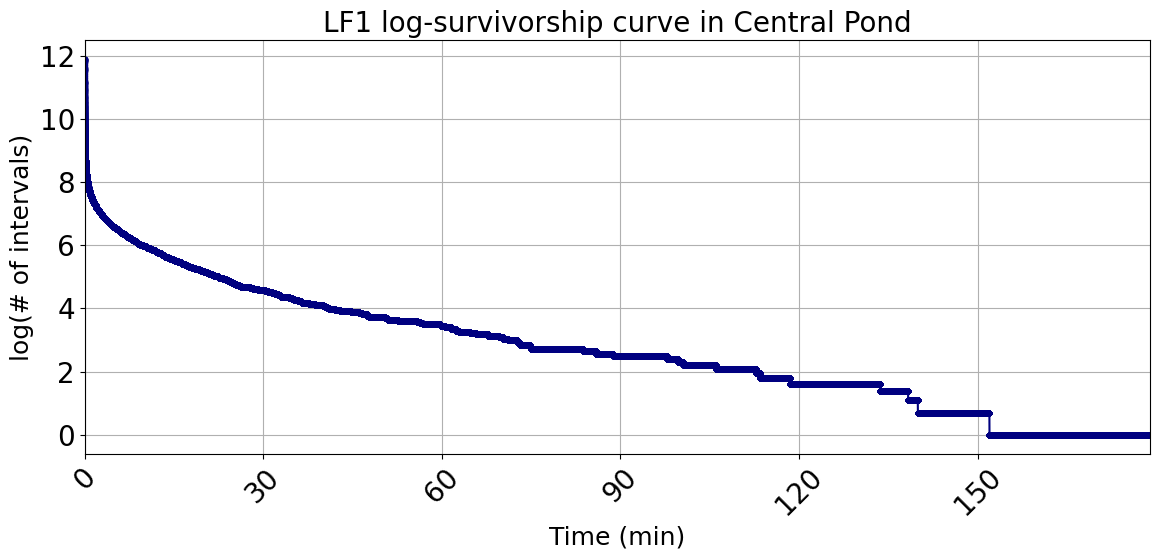

In [9]:
bt_plt.plot_log_survival(intervals_ms, survival, fig_details)

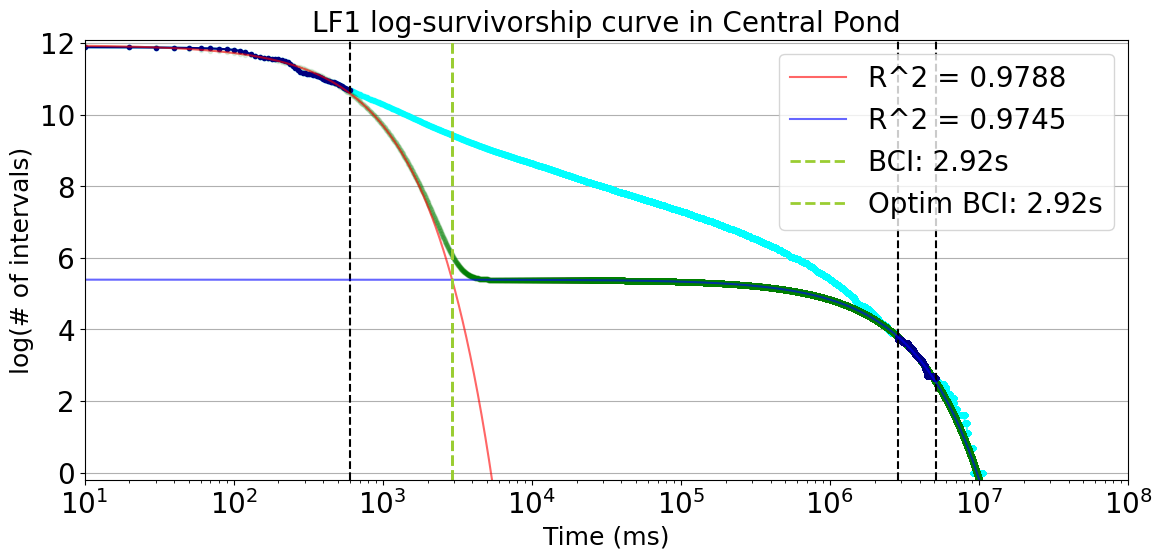

In [10]:
fig_details['time_end'] = 60000
bt_plt.plot_nlin_results_over_survival(intervals_ms, survival, fast_process, slow_process, nlin_results['solution'], nlin_results['bci'], bci, fig_details)

In [11]:
filepath_key = EXAMPLE_FILES_from_LOCATIONS[bout_params['site_key']][5]
filename = filepath_key.split('/')[-1]

file_path = Path(EXAMPLE_FILES_to_FILEPATHS[filepath_key])
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

data_params = dict()
data_params['site_tag'] = bout_params['site_key']
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
csv_path = Path(EXAMPLE_FILES_to_DETECTIONS[filepath_key])
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt_clustering.get_bout_params_from_location(dh.assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

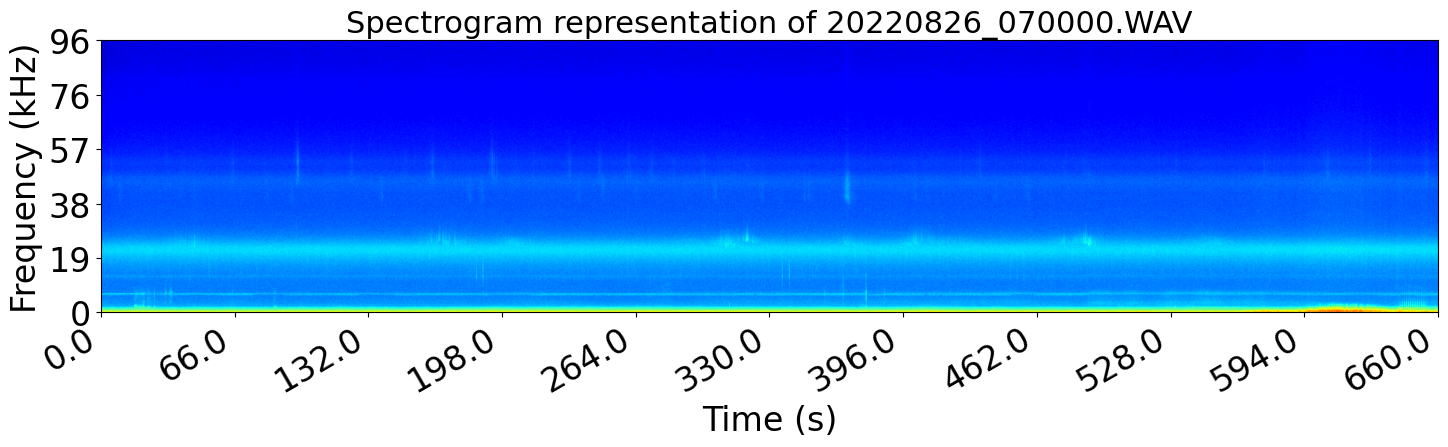

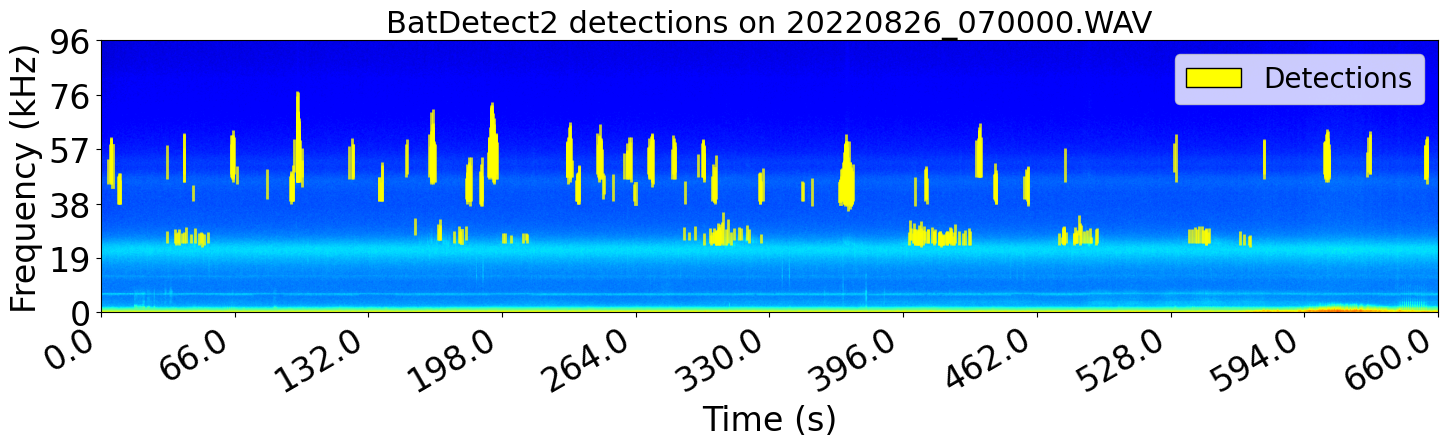

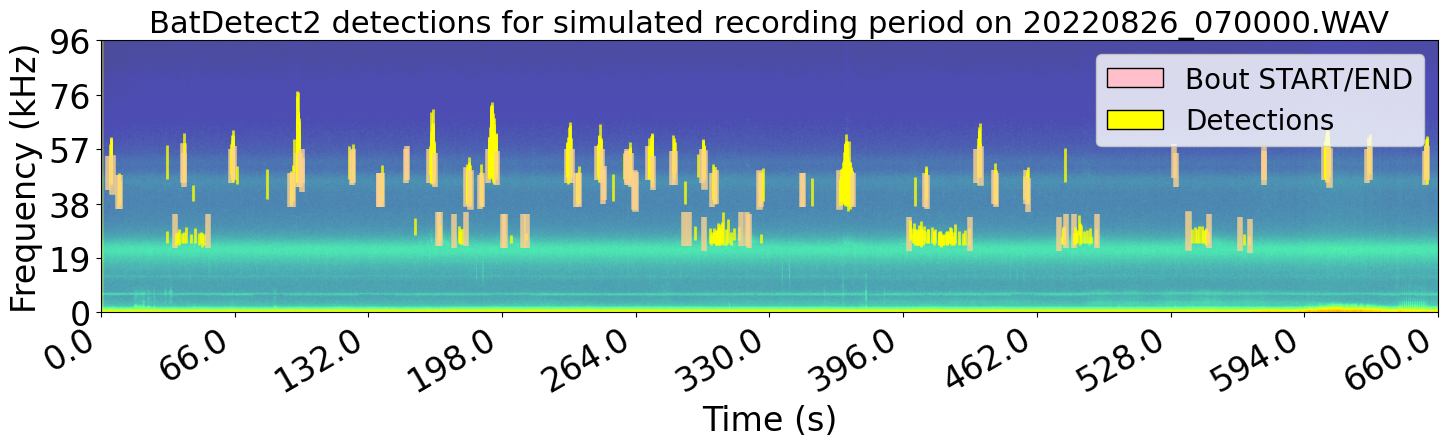

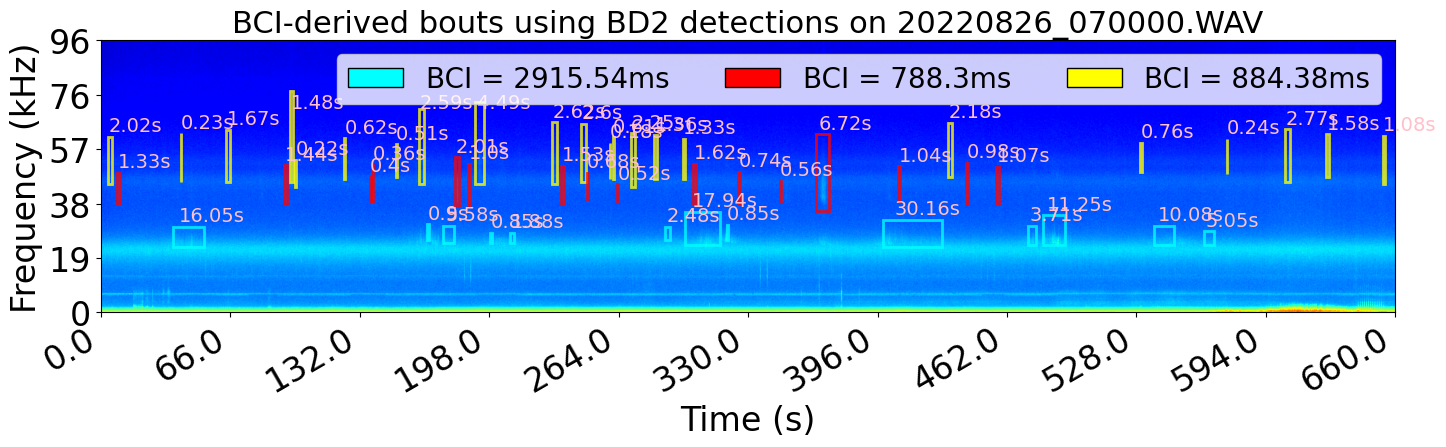

In [12]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [13]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 600
duration = 660
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

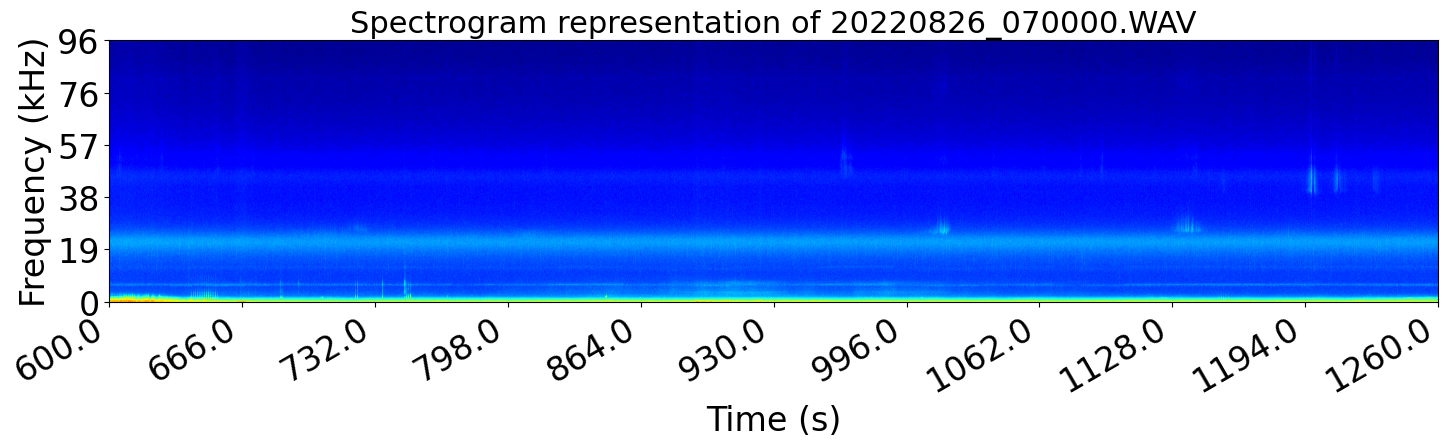

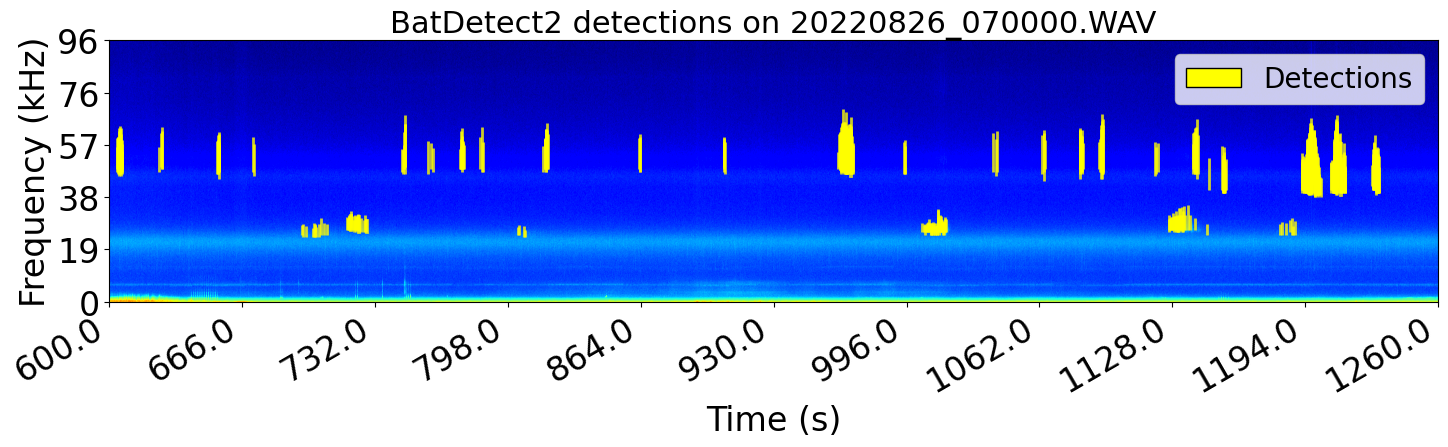

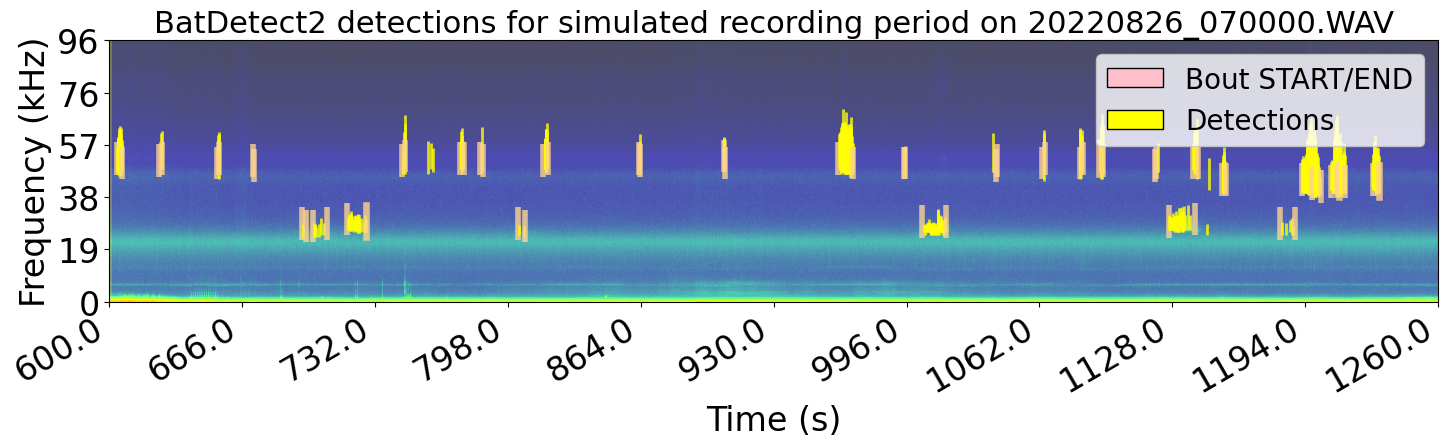

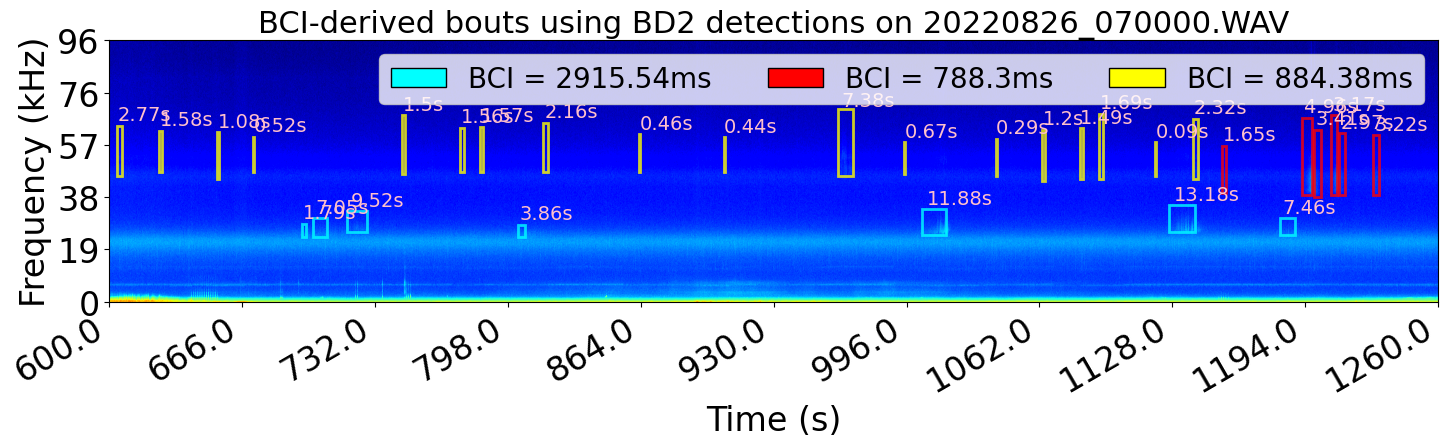

In [14]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

In [15]:
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 1200
duration = 600
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 55 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]
plot_dets = batdetect2_preds_with_bouttags.loc[np.logical_and(batdetect2_preds_with_bouttags['start_time'] > start, batdetect2_preds_with_bouttags['end_time'] < (start+duration))]
plot_bouts = bout_metrics.loc[np.logical_and(bout_metrics['start_time'] > start, bout_metrics['end_time'] < (start+duration))]

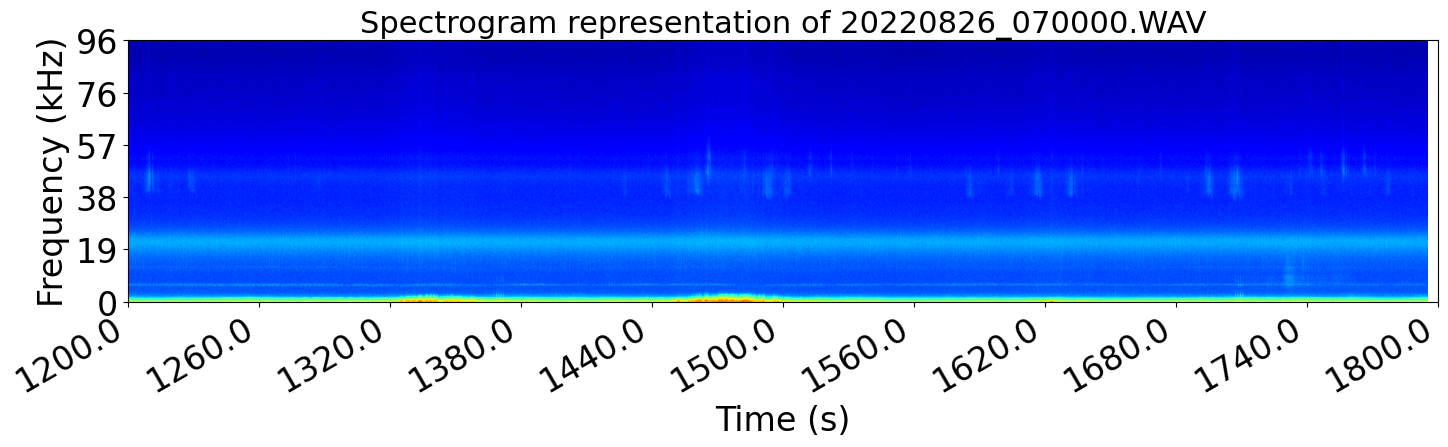

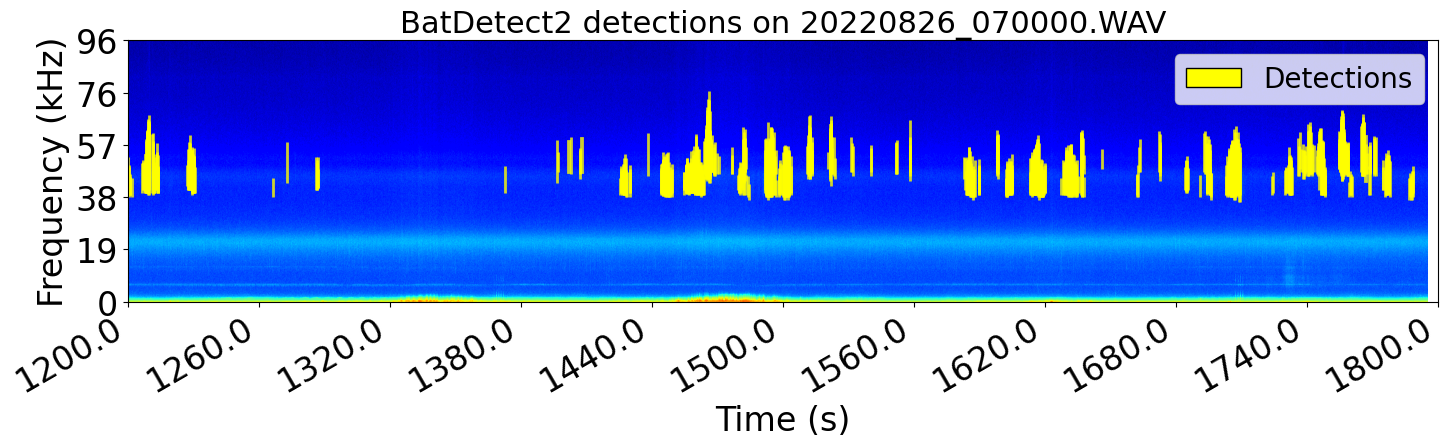

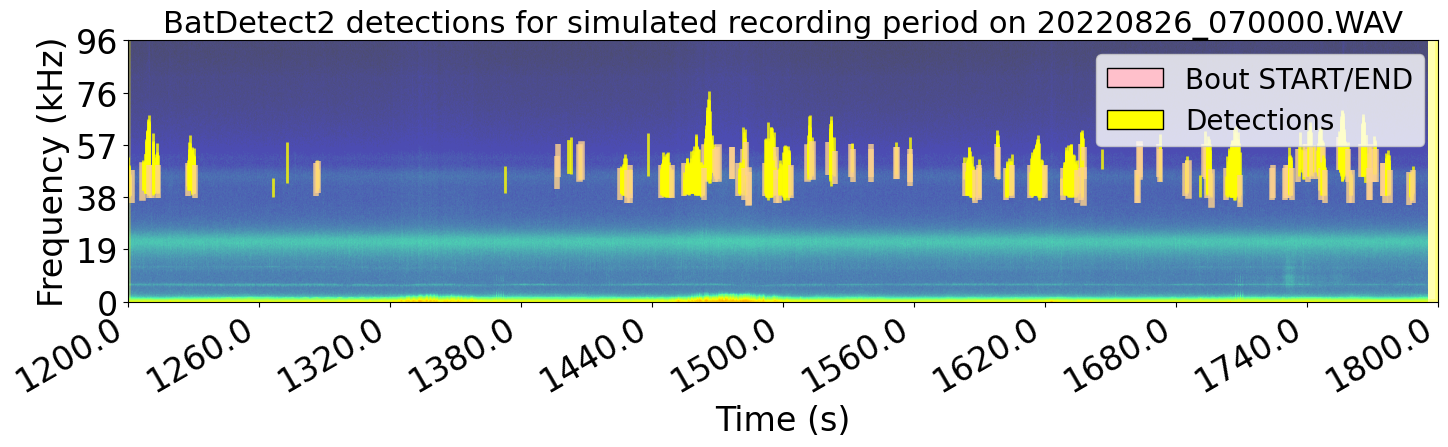

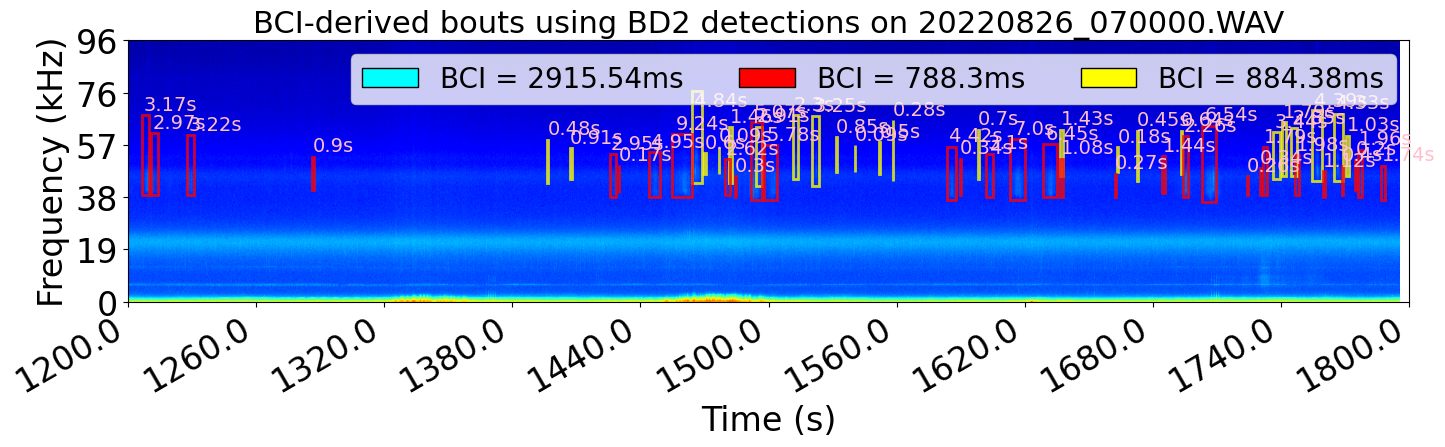

In [16]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)
bt_plt.plot_dets_with_bout_ID_over_audio_seg(audio_features, spec_features, data_params, plot_dets)
bt_plt.plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, plot_bouts)

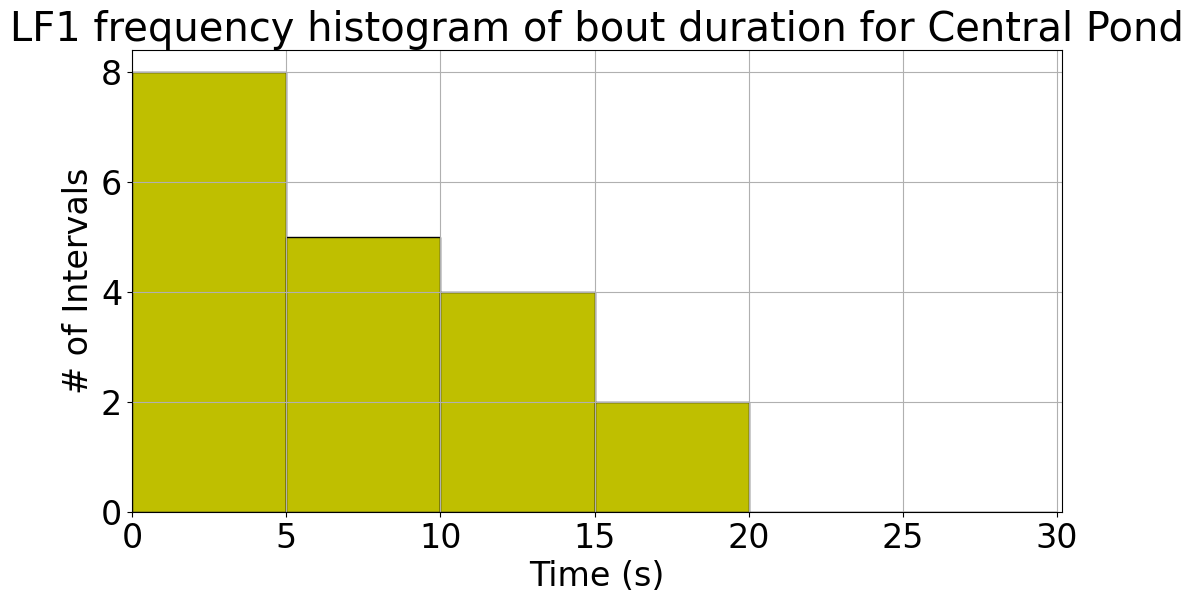

In [17]:
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
batdetect2_predictions = ss.simulate_dutycycle_on_detections(batdetect2_predictions_no_dutycycle, data_params['cur_dc_tag'])
bout_params = bt_clustering.get_bout_params_from_location(dh.assemble_initial_location_summary(data_params, file_paths), data_params)
batdetect2_preds_with_bouttags = bt_clustering.classify_bouts_in_bd2_predictions_for_freqgroups(batdetect2_predictions, bout_params)
bout_metrics = bt_clustering.construct_bout_metrics_from_location_df_for_freqgroups(batdetect2_preds_with_bouttags)
lf1_bout_metrics = bout_metrics.loc[bout_metrics['freq_group']==freq_key]
bout_durations = lf1_bout_metrics['bout_duration_in_secs'].values
plt.figure(figsize=(12, 6))
plt.title(f"{fig_details['freq_group']}frequency histogram of bout duration for {fig_details['site_name']}")
plt.hist(bout_durations, bins=np.arange(0, bout_durations.max()+1, 5), facecolor='y', edgecolor='k')
plt.xlim(0,  bout_durations.max())
plt.xlabel('Time (s)')
plt.grid(which='both')
plt.ylabel('# of Intervals')
plt.show()

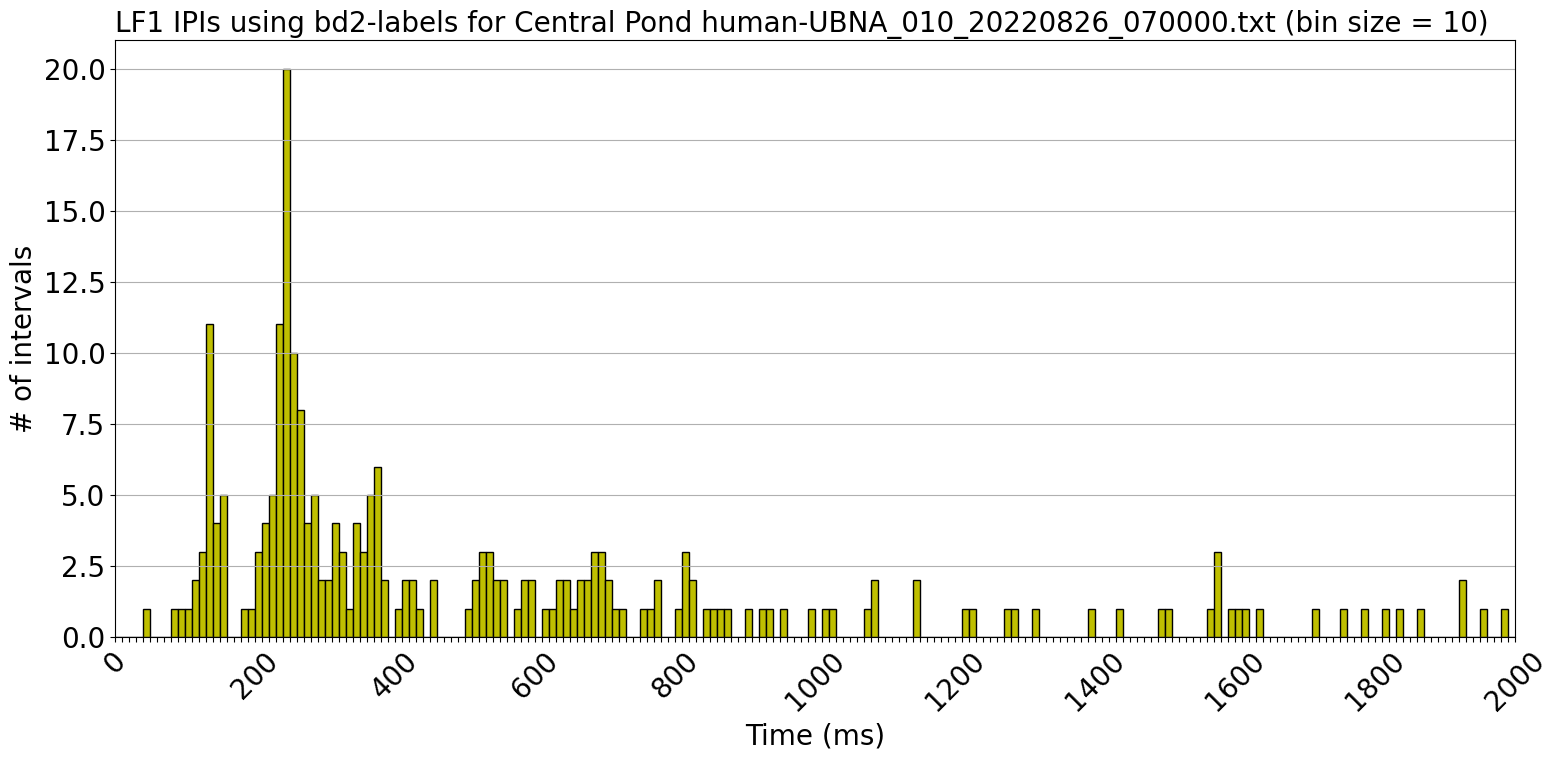

In [22]:
batdetect2_predictions_no_dutycycle = dh.assemble_single_bd2_output(csv_path, data_params)
freq_group_df = batdetect2_predictions_no_dutycycle.loc[batdetect2_predictions_no_dutycycle['freq_group']==freq_key]
intervals = pd.to_datetime(freq_group_df['call_start_time']) - pd.to_datetime(freq_group_df['call_end_time']).shift(1)
freq_group_df.insert(0, 'time_from_prev_call_end_time', intervals)
freq_group_df = freq_group_df.reset_index()
freq_group_df.drop(columns=freq_group_df.columns[0], inplace=True)

intervals = freq_group_df['time_from_prev_call_end_time'].values
valid_intervals = intervals[~np.isnan(intervals)]
ipis_ms = valid_intervals.astype('float32')/1e6
assert((len(ipis_ms)+1) == len(freq_group_df))

plt.rcParams.update({'font.size' : 20})
plt.figure(figsize=(16, 8))

fig_details['time_end'] = 2000

plt.title(f"{fig_details['freq_group']}IPIs using bd2-labels for {fig_details['site_name']} {file_path.name} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
plt.grid(axis='y')
bin_ticks = hist_bins.round(3)
bin_labels = [''] * len(bin_ticks)
bin_labels[::int(fig_details['time_end']/(10*fig_details['bin_step']))] = bin_ticks[::int(fig_details['time_end']/(10*fig_details['bin_step']))]

plt.xticks(bin_ticks, bin_labels, rotation=45)
plt.ylabel('# of intervals', fontsize=20)
plt.xlabel('Time (ms)', fontsize=20)
plt.xlim(0, fig_details['time_end'])
plt.tight_layout()
plt.show()

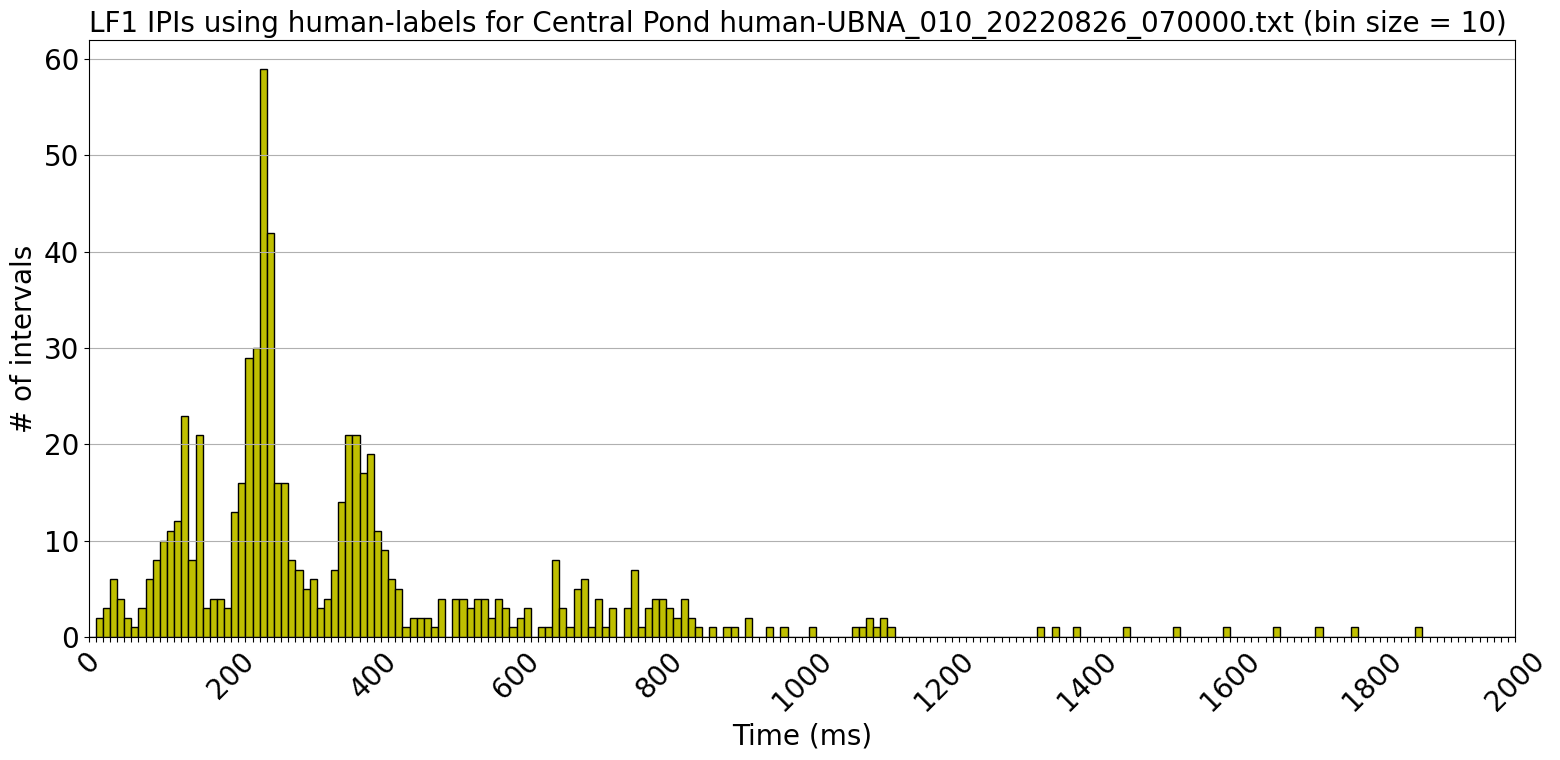

In [21]:
filepath_key = EXAMPLE_FILES_from_LOCATIONS[bout_params['site_key']][5]
filename = filepath_key.split('/')[-1]

file_path = Path(f'{Path.home()}/Downloads/human-UBNA_010_{filename}.txt')
if (file_path.is_file()):
    original_file_dets = pd.read_csv(file_path, sep='\t')
    original_file_dets['start_time'] = original_file_dets['Begin Time (s)']
    original_file_dets['end_time'] = original_file_dets['End Time (s)']
    original_file_dets['low_freq'] = original_file_dets['Low Freq (Hz)']
    original_file_dets['high_freq'] = original_file_dets['High Freq (Hz)']
    original_file_dets['input_file'] = filename
    original_file_dets = original_file_dets.loc[original_file_dets['View']=='Spectrogram 1']

    location_df = original_file_dets
    file_dts = pd.to_datetime(location_df['input_file'], format='%Y%m%d_%H%M%S', exact=False)

    anchor_start_times = file_dts + pd.to_timedelta(location_df['start_time'].values.astype('float64'), unit='S')
    anchor_end_times = file_dts + pd.to_timedelta(location_df['end_time'].values.astype('float64'), unit='S') 
    location_df.insert(0, 'freq_group', '')

    groups = FREQ_GROUPS[data_params['site_tag']]
    blue_group = groups['LF1']
    red_group = groups['HF1']
    yellow_group = groups['HF2']

    call_is_yellow = (location_df['low_freq']>=yellow_group[0])&(location_df['high_freq']<=yellow_group[1])
    call_is_red = (location_df['low_freq']>=red_group[0])&(location_df['high_freq']<=red_group[1])
    call_is_blue = (location_df['low_freq']>=blue_group[0])&(location_df['high_freq']<=blue_group[1])

    location_df.loc[call_is_yellow, 'freq_group'] = 'HF2'
    location_df.loc[call_is_red&(~(call_is_yellow)), 'freq_group'] = 'HF1'
    location_df.loc[call_is_blue&(~(call_is_red | call_is_yellow)), 'freq_group'] = 'LF1'

    location_df.insert(0, 'call_end_time', anchor_end_times)
    location_df.insert(0, 'call_start_time', anchor_start_times)
    location_df.insert(0, 'ref_time', anchor_start_times)

    location_df = location_df.sort_values('ref_time')
    location_df = location_df.reset_index()
    location_df.drop(columns=location_df.columns[0], inplace=True)

    location_df = location_df.loc[location_df['freq_group']==freq_key]
    intervals = pd.to_datetime(location_df['call_start_time']) - pd.to_datetime(location_df['call_end_time']).shift(1)
    location_df.insert(0, 'time_from_prev_call_end_time', intervals)
    location_df = location_df.reset_index()
    location_df.drop(columns=location_df.columns[0], inplace=True)

    intervals = location_df['time_from_prev_call_end_time'].values
    valid_intervals = intervals[~np.isnan(intervals)]
    ipis_ms = valid_intervals.astype('float32')/1e6
    assert((len(ipis_ms)+1) == len(location_df))

    plt.rcParams.update({'font.size' : 20})
    plt.figure(figsize=(16, 8))

    fig_details['time_end'] = 2000

    plt.title(f"{fig_details['freq_group']}IPIs using human-labels for {fig_details['site_name']} {file_path.name} (bin size = {fig_details['bin_step']})", loc='left', fontsize=20)
    hist_bins = np.arange(0, fig_details['time_end']+fig_details['bin_step'], fig_details['bin_step'])
    histogram = plt.hist(ipis_ms, bins=hist_bins, facecolor='y', edgecolor='k')
    plt.grid(axis='y')
    bin_ticks = hist_bins.round(3)
    bin_labels = [''] * len(bin_ticks)
    bin_labels[::int(fig_details['time_end']/(10*fig_details['bin_step']))] = bin_ticks[::int(fig_details['time_end']/(10*fig_details['bin_step']))]

    plt.xticks(bin_ticks, bin_labels, rotation=45)
    plt.ylabel('# of intervals', fontsize=20)
    plt.xlabel('Time (ms)', fontsize=20)
    plt.xlim(0, fig_details['time_end'])
    plt.tight_layout()
    plt.show()